## Goal of this project
Build a model to predict the total delivery duration seconds (as defined above).The main questions that were answered in this post are:
1. What model(s) are used
2. How I evaluated those modes' performance on the historical data
3. Data processing I performed on the data
4. Feature engineering choices I made
5. Other information I would like to share during the modeling approach.

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
pd.set_option('display.max_columns',None)

In [2]:
df=pd.read_csv("historical_data.csv")

In [3]:
df.shape

(197428, 16)

In [4]:
list(df.columns)

['market_id',
 'created_at',
 'actual_delivery_time',
 'store_id',
 'store_primary_category',
 'order_protocol',
 'total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration']

In [5]:
df['created_at']=pd.to_datetime(df['created_at'])
df['actual_delivery_time']=pd.to_datetime(df['actual_delivery_time'])

In [6]:
# Creat the target variable
df['actual_total_delivery_duration']=((df['actual_delivery_time']-df['created_at'])).dt.total_seconds()

In [7]:
# create new features which might be useful
df['estimated_non_prep_duration'] = df["estimated_store_to_consumer_driving_duration"] + df["estimated_order_place_duration"]
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0


In [8]:
df.shape

(197428, 18)

In [9]:
#df["busy_dashers_ratio"] = df["total_busy_dashers"] / df["total_onshift_dashers"]


In [10]:

# check ids and decide whether to encode or not
df["market_id"].nunique()

6

In [11]:
df["store_id"].nunique()

6743

In [12]:
df["order_protocol"].nunique()

7

In [13]:
pd.DataFrame((df.isnull().sum()/df.shape[0])*100, columns=['NA%']).sort_values(['NA%'], ascending=False)

,NA%
total_onshift_dashers,8.236927
total_outstanding_orders,8.236927
total_busy_dashers,8.236927
store_primary_category,2.411006
order_protocol,0.503981
market_id,0.499929
estimated_store_to_consumer_driving_duration,0.266426
estimated_non_prep_duration,0.266426
actual_delivery_time,0.003546
actual_total_delivery_duration,0.003546


In [14]:
# create dictionary with most repeated categories of each store to fill null rows where it is possible
store_id_unique = df["store_id"].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}

In [15]:
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
df["nan_free_store_primary_category"] = df.store_id.apply(fill)


In [16]:
df[['store_id','store_primary_category','nan_free_store_primary_category']]

,store_id,store_primary_category,nan_free_store_primary_category
0,1845,american,american
1,5477,mexican,indian
2,5477,NaN,indian
3,5477,NaN,indian
4,5477,NaN,indian
...,...,...,...
197423,2956,fast,fast
197424,2956,fast,fast
197425,2956,fast,fast
197426,3630,sandwich,sandwich


In [17]:
# create dummies for order protocol
order_protocol_dummies = pd.get_dummies(df.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [18]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(df.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [19]:
# create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(df.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# drop unnecessary columns
# 'estimated_store_to_consumer_driving_duration' 'estimated_order_place_duration' will be dropped, because a new variable
# called estimated_non_prep_duration was made by these two variables
train_df = df.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time", 
                                        "nan_free_store_primary_category", "order_protocol",'estimated_store_to_consumer_driving_duration',
                             'estimated_order_place_duration'])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,actual_total_delivery_duration,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,3779.0,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,4024.0,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,1781.0,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,3075.0,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,2390.0,1096.0


In [21]:
train_df.shape

(197428, 10)

In [22]:
# concat all
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
# align dtype over dataset
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,actual_total_delivery_duration,estimated_non_prep_duration,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,3779.0,1307.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,4024.0,1136.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,1781.0,1136.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,3075.0,735.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,2390.0,1096.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
pd.DataFrame(train_df.isnull().sum(),columns=['na']).sort_values('na', ascending=False)[:10]

,na
total_onshift_dashers,16262
total_busy_dashers,16262
total_outstanding_orders,16262
estimated_non_prep_duration,526
actual_total_delivery_duration,7
total_items,0
category_japanese,0
category_moroccan,0
category_middle-eastern,0
category_mexican,0


In [24]:
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nans
train_df.dropna(inplace=True)
train_df.shape

(180677, 97)

In [25]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,actual_total_delivery_duration,estimated_non_prep_duration,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,category_breakfast,category_british,category_bubble-tea,category_burger,category_burmese,category_cafe,category_cajun,category_caribbean,category_catering,category_cheese,category_chinese,category_chocolate,category_comfort-food,category_convenience-store,category_dessert,category_dim-sum,category_ethiopian,category_european,category_fast,category_filipino,category_french,category_gastropub,category_german,category_gluten-free,category_greek,category_hawaiian,category_indian,category_indonesian,category_irish,category_italian,category_japanese,category_korean,category_kosher,category_latin-american,category_lebanese,category_malaysian,category_mediterranean,category_mexican,category_middle-eastern,category_moroccan,category_nepalese,category_other,category_pakistani,category_pasta,category_persian,category_peruvian,category_pizza,category_russian,category_salad,category_sandwich,category_seafood,category_singaporean,category_smoothie,category_soup,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,180677.000000,180677.000000,180677.000000,180677.00000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.0,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000,180677.000000
mean,3.208870,2699.123535,2.678133,684.87146,1161.022095,44.820824,41.755314,58.072189,2866.881348,854.839722,0.279194,0.117779,0.265014,0.097168,0.231900,0.003764,0.000105,0.208887,0.302352,0.119711,0.261483,0.098873,0.003614,0.000548,0.000055,0.009752,0.000006,0.103937,0.000376,0.013660,0.014988,0.000011,0.001638,0.027497,0.000681,0.002430,0.056991,0.003531,0.011241,0.002092,0.001328,0.008756,0.000133,0.047970,0.000006,0.000149,0.001849,0.046658,0.005634,0.000614,0.000116,0.036767,0.001483,0.003099,0.001035,0.000354,0.000105,0.016676,0.008302,0.035992,0.0,0.000293,0.037719,0.046824,0.009448,0.000288,0.002723,0.000636,0.000515,0.028631,0.087720,0.007992,0.000144,0.001671,0.020611,0.000764,0.003531,0.003415,0.001334,0.089126,0.000055,0.019787,0.050720,0.015071,0.000155,0.008468,0.000327,0.000221,0.000138,0.005679,0.011866,0.000697,0.035157,0.001190,0.001301,0.004157,0.030945
std,2.673251,1828.945557,1.627

### 1. Feature selection
Given there are 100 variables in the preprocessed data, it will be difficult to tell the result if we do collinearity check based on heat map. Therefore, we will do the following work:
1. Perform PCA
2. Perform feature selection based on the variable importance based on Random Forest.

In [26]:
# 1. check uni value columns
for col in train_df.columns:
    if len(train_df[col].unique())==1:
        print(col)

category_indonesian


In [27]:
# Given the column category_indonesian has single value, it will not provide extra information for the prediction,
# Therefore, we will remove this variable
train_df=train_df.drop(columns='category_indonesian')
train_df.shape

(180677, 96)

### 1.1 Do PCA on original data after preprocessed

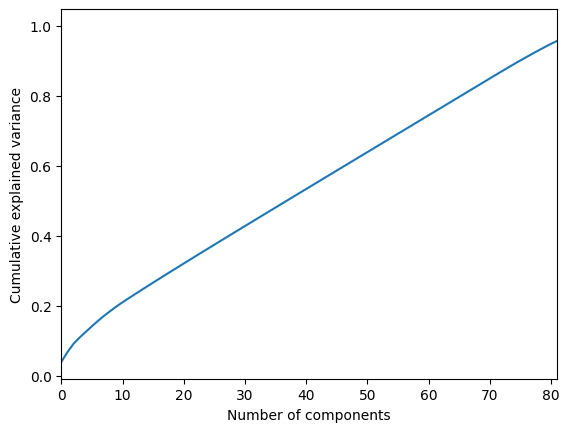

In [112]:

#X_train, X_test, y_train, y_test

# Finding normalised array of X_Train
X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA()  # choose the number of components, e.g., 2
principal_components = pca.fit_transform(X_std)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Applying PCA does not really help with reducing the dimentionality, since it needs at least 80 variables to explaine around 90% variance in dependent variable.

Therefore, we will not apply PCA at this moment.

### 1.2 Check the important variable based on Random forest
- select features
- train models using seleced features

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in multicollinearity check part

X = train_df.drop(columns=['actual_total_delivery_duration'])
y = train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [41]:
X.shape,y.shape

((180677, 95), (180677,))

In [29]:
# Initialize the Random Forest regressor
forest = RandomForestRegressor(random_state=42)

# Fit the regressor to the training data
forest.fit(X_train, y_train)

# Get the feature importances
importances = forest.feature_importances_

In [30]:
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
features = features.sort_values(by='Importance', ascending=False)
features['Importance'].sort_values(ascending=False).round(3)
# will select the first 20, 40, 50

1     0.132
3     0.129
8     0.094
7     0.092
46    0.087
      ...  
15    0.000
23    0.000
25    0.000
30    0.000
43    0.000
Name: Importance, Length: 95, dtype: float64

In [163]:
features['']

,Feature,Importance
1,subtotal,1.323467e-01
3,min_item_price,1.289216e-01
8,estimated_non_prep_duration,9.428799e-02
7,total_outstanding_orders,9.158892e-02
46,category_dessert,8.721297e-02
...,...,...
15,order_protocol_7.0,1.815494e-06
23,category_african,8.297403e-07
25,category_alcohol-plus-food,3.302208e-07
30,category_belgian,2.704684e-07


In [166]:
features['Importance'][0],features['Importance'][10]

(0.0181814542350189, 0.0040150508573255795)

We will select 3 sets of features, and use those feature sets to fit model to see which set of feature can provide a better performance. We will pick the first 15, first 30, and first 50 features as different sets.

## 2. Fit models with selected feature sets

In [31]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor (does not need much tuning, and it is good for handling the missing values)
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [32]:
#x_selected15=X[features['Feature'][:15]]
#x_selected30=X[features['Feature'][:30]]
#x_selected50=X[features['Feature'][:50]]

In [33]:
featuer_sets={
    'x_selected15':X[features['Feature'][:15]].columns.tolist(),
    'x_selected30':X[features['Feature'][:30]].columns.tolist(),
    'x_selected50':X[features['Feature'][:50]].columns.tolist()
}

In [134]:
for key in featuer_sets.keys():
    featuer_names=featuer_sets[key]
    newinput=X[featuer_names]
    x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)
    print('DecisionTreeRegressor:{}'.format(key))
    model=DecisionTreeRegressor(max_depth=3)# number of the tree and depth of each tree 
    # Perform cross-validation on the training set
    scores = cross_val_score(model, x_train_select, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print("Cross-Validation Results on Training Set")
    print("Mean Squared Error: %0.2f (+/- %0.2f)" % (mse_scores.mean(), mse_scores.std() * 2))

    # Train the model on the entire training set
    model.fit(x_train_select, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test_select)
    mse_test = mean_squared_error(y_test, y_pred)
    print("\nFinal Model Evaluation on Test Set")
    print("Mean Squared Error on Test Set: %0.2f" % mse_test)
    print('----------------------------------------------')
    print()


DecisionTreeRegressor:x_selected15
Cross-Validation Results on Training Set
Mean Squared Error: 2912139.89 (+/- 4301199.64)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1316261.80
----------------------------------------------

DecisionTreeRegressor:x_selected30
Cross-Validation Results on Training Set
Mean Squared Error: 2912139.89 (+/- 4301199.64)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1316261.80
----------------------------------------------

DecisionTreeRegressor:x_selected50
Cross-Validation Results on Training Set
Mean Squared Error: 2912139.89 (+/- 4301199.64)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1316261.80
----------------------------------------------



In [131]:
for key in featuer_sets.keys():
    featuer_names=featuer_sets[key]
    newinput=X[featuer_names]
    x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)
    print('XGBoost:{}'.format(key))
    model=XGBRegressor(n_estimators=100,max_depth=3)# number of the tree and depth of each tree 
    # Perform cross-validation on the training set
    scores = cross_val_score(model, x_train_select, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print("Cross-Validation Results on Training Set")
    print("Mean Squared Error: %0.2f (+/- %0.2f)" % (mse_scores.mean(), mse_scores.std() * 2))

    # Train the model on the entire training set
    model.fit(x_train_select, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test_select)
    mse_test = mean_squared_error(y_test, y_pred)
    print("\nFinal Model Evaluation on Test Set")
    print("Mean Squared Error on Test Set: %0.2f" % mse_test)
    print('----------------------------------------------')
    print()


XGBoost:x_selected15
Cross-Validation Results on Training Set
Mean Squared Error: 2826179.02 (+/- 4169340.29)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1158131.75
----------------------------------------------

XGBoost:x_selected30
Cross-Validation Results on Training Set
Mean Squared Error: 2726768.80 (+/- 4288951.54)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1097284.62
----------------------------------------------

XGBoost:x_selected50
Cross-Validation Results on Training Set
Mean Squared Error: 2745301.24 (+/- 4252029.64)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1130925.50
----------------------------------------------



In [130]:

for key in featuer_sets.keys():
    featuer_names=featuer_sets[key]
    newinput=X[featuer_names]
    x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)
    print('Ridge:{}'.format(key))
    model=linear_model.Ridge()
    # Perform cross-validation on the training set
    scores = cross_val_score(model, x_train_select, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print("Cross-Validation Results on Training Set")
    print("Mean Squared Error: %0.2f (+/- %0.2f)" % (mse_scores.mean(), mse_scores.std() * 2))

    # Train the model on the entire training set
    model.fit(x_train_select, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test_select)
    mse_test = mean_squared_error(y_test, y_pred)
    print("\nFinal Model Evaluation on Test Set")
    print("Mean Squared Error on Test Set: %0.2f" % mse_test)
    print('----------------------------------------------')
    print()


Ridge:x_selected15
Cross-Validation Results on Training Set
Mean Squared Error: 2742928.38 (+/- 4299488.68)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1145327.25
----------------------------------------------

Ridge:x_selected30
Cross-Validation Results on Training Set
Mean Squared Error: 2732943.51 (+/- 4300829.51)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1130463.25
----------------------------------------------

Ridge:x_selected50
Cross-Validation Results on Training Set
Mean Squared Error: 2729458.23 (+/- 4301304.37)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1127561.12
----------------------------------------------



In [139]:
for key in featuer_sets.keys():
    featuer_names=featuer_sets[key]
    newinput=X[featuer_names]
    x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)
    print('RandomForest:{}'.format(key))
    model=RandomForestRegressor()
    # Perform cross-validation on the training set
    scores = cross_val_score(model, x_train_select, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print("Cross-Validation Results on Training Set")
    print("Mean Squared Error: %0.2f (+/- %0.2f)" % (mse_scores.mean(), mse_scores.std() * 2))

    # Train the model on the entire training set
    model.fit(x_train_select, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test_select)
    mse_test = mean_squared_error(y_test, y_pred)
    print("\nFinal Model Evaluation on Test Set")
    print("Mean Squared Error on Test Set: %0.2f" % mse_test)
    print('----------------------------------------------')
    print()


RandomForest:x_selected15
Cross-Validation Results on Training Set
Mean Squared Error: 2909764.14 (+/- 4338247.23)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1279196.53
----------------------------------------------

RandomForest:x_selected30
Cross-Validation Results on Training Set
Mean Squared Error: 2981095.93 (+/- 4384689.68)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1427177.42
----------------------------------------------

RandomForest:x_selected50
Cross-Validation Results on Training Set
Mean Squared Error: 2898248.73 (+/- 4362857.49)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1319399.02
----------------------------------------------



Comparing with Decision Tree, XGBoost, and Ridge regression, the Random forest runs very slow. 

Given the models above have pretty similar performance, we will test out how the models behave after the input data is scalded. This time, we will not include Random forest in our objective models.

#### Do the same process with scalded data:


In [152]:
from sklearn.preprocessing import StandardScaler
# Initialize the scaler
scaler = StandardScaler()
# Fit the scaler to the data and transform
standardized_data = scaler.fit_transform(X)
standardized_data=pd.DataFrame(standardized_data)
print("Standardized Data:\n", standardized_data.shape)
print('Original data:\n', X.shape)

Standardized Data:
 (180677, 95)
Original data:
 (180677, 95)


In [155]:
standardized_data.columns=X.columns

In [156]:
featuer_sets={
    'x_selected15':standardized_data[features['Feature'][:15]].columns.tolist(),
    'x_selected30':standardized_data[features['Feature'][:30]].columns.tolist(),
    'x_selected50':standardized_data[features['Feature'][:50]].columns.tolist()
}

In [159]:
for key in featuer_sets.keys():
    featuer_names=featuer_sets[key]
    newinput=standardized_data[featuer_names]
    x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)
    print('After scaled\n')
    print('DecisionTreeRegressor:{}'.format(key))
    model=DecisionTreeRegressor(max_depth=3)# number of the tree and depth of each tree 
    # Perform cross-validation on the training set
    scores = cross_val_score(model, x_train_select, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    
    print("Cross-Validation Results on Training Set")
    print("Mean Squared Error: %0.2f (+/- %0.2f)" % (mse_scores.mean(), mse_scores.std() * 2))

    # Train the model on the entire training set
    model.fit(x_train_select, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test_select)
    mse_test = mean_squared_error(y_test, y_pred)
    print("\nFinal Model Evaluation on Test Set")
    print("Mean Squared Error on Test Set: %0.2f" % mse_test)
    print('----------------------------------------------')
    print()


After scaled

DecisionTreeRegressor:x_selected15
Cross-Validation Results on Training Set
Mean Squared Error: 2912139.89 (+/- 4301199.64)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1316261.80
----------------------------------------------

After scaled

DecisionTreeRegressor:x_selected30
Cross-Validation Results on Training Set
Mean Squared Error: 2912139.89 (+/- 4301199.64)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1316261.80
----------------------------------------------

After scaled

DecisionTreeRegressor:x_selected50
Cross-Validation Results on Training Set
Mean Squared Error: 2912139.89 (+/- 4301199.64)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1316261.80
----------------------------------------------



In [160]:
for key in featuer_sets.keys():
    featuer_names=featuer_sets[key]
    newinput=standardized_data[featuer_names]
    x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)
    print('XGBoost:{}'.format(key))
    model=XGBRegressor(n_estimators=100,max_depth=3)# number of the tree and depth of each tree 
    # Perform cross-validation on the training set
    scores = cross_val_score(model, x_train_select, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print("Cross-Validation Results on Training Set")
    print("Mean Squared Error: %0.2f (+/- %0.2f)" % (mse_scores.mean(), mse_scores.std() * 2))

    # Train the model on the entire training set
    model.fit(x_train_select, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test_select)
    mse_test = mean_squared_error(y_test, y_pred)
    print("\nFinal Model Evaluation on Test Set")
    print("Mean Squared Error on Test Set: %0.2f" % mse_test)
    print('----------------------------------------------')
    print()


XGBoost:x_selected15
Cross-Validation Results on Training Set
Mean Squared Error: 2826184.08 (+/- 4169353.13)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1158131.75
----------------------------------------------

XGBoost:x_selected30
Cross-Validation Results on Training Set
Mean Squared Error: 2726769.40 (+/- 4288953.20)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1097284.62
----------------------------------------------

XGBoost:x_selected50
Cross-Validation Results on Training Set
Mean Squared Error: 2744943.69 (+/- 4252615.29)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1130925.50
----------------------------------------------



In [161]:

for key in featuer_sets.keys():
    featuer_names=featuer_sets[key]
    newinput=standardized_data[featuer_names]
    x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)
    print('After scaled\n')
    print('Ridge:{}'.format(key))
    model=linear_model.Ridge()
    # Perform cross-validation on the training set
    scores = cross_val_score(model, x_train_select, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print("Cross-Validation Results on Training Set")
    print("Mean Squared Error: %0.2f (+/- %0.2f)" % (mse_scores.mean(), mse_scores.std() * 2))

    # Train the model on the entire training set
    model.fit(x_train_select, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test_select)
    mse_test = mean_squared_error(y_test, y_pred)
    print("\nFinal Model Evaluation on Test Set")
    print("Mean Squared Error on Test Set: %0.2f" % mse_test)
    print('----------------------------------------------')
    print()

After scaled

Ridge:x_selected15
Cross-Validation Results on Training Set
Mean Squared Error: 2742928.64 (+/- 4299487.39)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1145327.12
----------------------------------------------

After scaled

Ridge:x_selected30
Cross-Validation Results on Training Set
Mean Squared Error: 2732944.48 (+/- 4300825.32)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1130463.12
----------------------------------------------

After scaled

Ridge:x_selected50
Cross-Validation Results on Training Set
Mean Squared Error: 2729459.14 (+/- 4301303.76)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1127560.75
----------------------------------------------



Obviously, scaling did not help with improving the model performance. Among all three models, the XGBoost had the best performance, with the selected first 30 imporance features.

We will pick the XGBoost be the final model.

#### To have a better model, we will have some tuning process on XGBoost, see whether we can improve its performance or not.

In [169]:
# Current XGBOOST before parameter tunning
for key in featuer_sets.keys():
    featuer_names=featuer_sets[key]
    newinput=X[featuer_names]
    x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)
    print('XGBoost:{}'.format(key))
    model=XGBRegressor(n_estimators=100,max_depth=3)# number of the tree and depth of each tree 
    # Perform cross-validation on the training set
    scores = cross_val_score(model, x_train_select, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print("Cross-Validation Results on Training Set")
    print("Mean Squared Error: %0.2f (+/- %0.2f)" % (mse_scores.mean(), mse_scores.std() * 2))

    # Train the model on the entire training set
    model.fit(x_train_select, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(x_test_select)
    mse_test = mean_squared_error(y_test, y_pred)
    print("\nFinal Model Evaluation on Test Set")
    print("Mean Squared Error on Test Set: %0.2f" % mse_test)
    print('----------------------------------------------')
    print()

XGBoost:x_selected15
Cross-Validation Results on Training Set
Mean Squared Error: 2826179.02 (+/- 4169340.29)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1158131.75
----------------------------------------------

XGBoost:x_selected30
Cross-Validation Results on Training Set
Mean Squared Error: 2726768.80 (+/- 4288951.54)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1097284.62
----------------------------------------------

XGBoost:x_selected50
Cross-Validation Results on Training Set
Mean Squared Error: 2745301.24 (+/- 4252029.64)

Final Model Evaluation on Test Set
Mean Squared Error on Test Set: 1130925.50
----------------------------------------------



All the parameters that need to be tunned

In [170]:
#n_estimators: Number of boosting rounds.
#learning_rate: Step size shrinkage used to prevent overfitting.
#max_depth: Maximum depth of a tree.
#subsample: Subsample ratio of the training instances.
#colsample_bytree: Subsample ratio of columns when constructing each tree.

In [186]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [173]:
newinput=featuer_names[:30]   
x_train_select,x_test_select, y_train, y_test=train_test_split(newinput,y, test_size=0.2, random_state=328)

In [204]:
x_train_select.shape,x_test_select.shape

((144541, 50), (36136, 50))

In [182]:
xg_reg = XGBRegressor(objective ='reg:squarederror')


In [183]:
parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}


In [187]:
grid_search = GridSearchCV(estimator=xg_reg, param_grid=parameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(x_train_select, y_train)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [205]:
best_parameters = grid_search.best_params_
best_result = grid_search.best_score_
print(f"Best Parameters: {best_parameters}")
print(f"Best Result: {best_result}")

# Predict on test set
predictions = grid_search.predict(x_test_select)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9}
Best Result: -2707611.5416666665
Mean Squared Error: 1090321.375


In [206]:
best_model = grid_search.best_estimator_
best_model 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

#### Extrac final model

In [210]:
import joblib

# Save the model
joblib.dump(best_model, 'best_xgb_model.pkl')

# To load the model later
# loaded_model = joblib.load('best_xgb_model.pkl')


['best_xgb_model.pkl']